## Overview

In this notebook, we use the TakeCV corpus as train and validation data to train Naive Bayes classifiers. Then, we test the models on the Survey corpus. 
- in the first section, we import the TakeCV data and Multinomial NB from `sklearn`.
- We initiate baseline NB, which takes bags-of-unigrams as input. Baseline NB are trained on three types of labels: full labels (color and shape), color, and shape. As well, we assess the results of combining predictions from the color model and the shape model (color + shape).
- Then, we build different NB models that take unigrams, bigrams, trigrams, and four-grams. We also report 5-fold cross-validation results, as seen below.
- The last section, we import the Survey data and test our models on it.

# Import data and model
## data

In [2]:
import pandas as pd
import re

In [3]:
df = pd.read_csv('data_clean.csv')
print (df.shape)

(525, 2)


In [1]:
# split label into color and shape
df[['color','shape']] = df['label'].str.split(' ',expand=True)

In [5]:
# check if split correctly
print (df['color'].value_counts())
print (df['shape'].value_counts())

wooden    153
blue       84
green      68
orange     51
yellow     48
gray       33
pink       30
red        30
purple     28
Name: color, dtype: int64
t    56
f    50
w    47
u    47
i    44
v    44
l    43
z    42
p    42
y    39
n    36
x    35
Name: shape, dtype: int64


## MultinomialNB

https://practicaldatascience.co.uk/machine-learning/how-to-create-a-naive-bayes-text-classification-model-using-scikit-learn

In [6]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Baseline NB

In [20]:
# default setting
test_size = 0.2
seed = 1

# transform df into BoW and define X,y
count_vec = CountVectorizer(stop_words='english', ngram_range=ngram_range)
bow = count_vec.fit_transform(df['correct'])
bow = np.array(bow.todense())

# define X,y
X = bow
y = df['label']

# shuffle and split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = test_size, random_state = seed)

# split labels
y_train_color = [i.split(' ')[0] for i in y_train]
y_train_shape = [i.split(' ')[1] for i in y_train]
y_test_color = [i.split(' ')[0] for i in y_test]
y_test_shape = [i.split(' ')[1] for i in y_test]

In [21]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((420, 3198), (105, 3198), (420,), (105,))

In [22]:
# train models
label_model = MultinomialNB().fit(X_train,y_train)
color_model = MultinomialNB().fit(X_train,y_train_color)
shape_model = MultinomialNB().fit(X_train,y_train_shape)

# get predictions
y_pred = label_model.predict(X_test)
color_pred = color_model.predict(X_test)
shape_pred = shape_model.predict(X_test)

cs_pred = []

for x,y in zip(X_test, y_test):
    c_pred = color_model.predict(x.reshape(1,-1))
    s_pred = shape_model.predict(x.reshape(1,-1))

    color_shape_pred = c_pred.item()+' '+s_pred.item()
    cs_pred.append(color_shape_pred)
    
    print ('true:', y, ': pred:', color_shape_pred)   

# cannot do cross-validation, except by manual coding

true: wooden z : pred: wooden y
true: wooden p : pred: orange y
true: orange u : pred: orange u
true: wooden f : pred: wooden w
true: gray f : pred: blue v
true: purple n : pred: purple n
true: blue v : pred: blue v
true: wooden i : pred: wooden y
true: pink p : pred: green p
true: orange u : pred: yellow t
true: wooden i : pred: wooden y
true: blue v : pred: blue v
true: yellow u : pred: yellow u
true: purple n : pred: wooden n
true: green t : pred: green t
true: wooden p : pred: purple p
true: wooden l : pred: wooden p
true: blue z : pred: blue v
true: wooden p : pred: wooden f
true: blue v : pred: blue i
true: wooden f : pred: wooden p
true: red x : pred: wooden x
true: red x : pred: red x
true: blue v : pred: blue v
true: wooden l : pred: wooden y
true: pink p : pred: pink p
true: wooden p : pred: wooden y
true: pink p : pred: pink p
true: gray f : pred: gray f
true: wooden n : pred: wooden f
true: orange l : pred: orange l
true: wooden y : pred: wooden y
true: gray f : pred: gray 

In [23]:
# print accuracy
# this is accuracy on test data
print('Acc on full label:', accuracy_score(np.array(y_test), y_pred))
print('Acc on color:', accuracy_score(y_test_color, color_pred))
print('Acc on shape:', accuracy_score(y_test_shape, shape_pred))
print('Acc on color + shape:', accuracy_score(y_test, cs_pred))

Acc on full label: 0.5428571428571428
Acc on color: 0.7714285714285715
Acc on shape: 0.5714285714285714
Acc on color + shape: 0.47619047619047616


# NB Extension

In [13]:
# default setting
ngram_range = (1,3) # n-grams (min, max)
cv = 5 # cross validation folds: set to 5 because the smallest class have only 5 instances

def transform_data(label, ngram_range):
    # transform df into BoW and define X,y
    count_vec = CountVectorizer(stop_words='english', ngram_range=ngram_range)
    bow = count_vec.fit_transform(df['text'])
    bow = np.array(bow.todense())

    # define X,y
    X = bow
    y = df[label]

    return X, y


def train_and_predict(X,y,test_size=test_size, seed=seed):
    """
    input: X (vectorized, as np.array), y (label, as string)
    print: results on accuracy
    output: y_prediction on test data
    
    """
    # split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_size,
                                                    random_state=seed, 
                                                    stratify=y) # make sure to split instances from each class of y
    # train and predict
    # initialize model
    batch_model = MultinomialNB().fit(np.random.rand(X_train.shape[0],X_train.shape[1]), y_train) # feed with random data
    
    # pre-trained model's prediction
    y_pred = batch_model.predict(X_test)
    print('Pre-trained accuracy:', accuracy_score(y_test, y_pred)) 
    print('Pre-trained F1 score:', f1_score(y_test, y_pred, average="macro"))

    # trained model's prediction
    batch_model.fit(X_train, y_train)
    y_pred = batch_model.predict(X_test)
    
    # get scores
    print('Trained accuracy:', accuracy_score(y_test, y_pred)) 
    print('Trained F1 score:', f1_score(y_test, y_pred, average="macro"),'\n')
    
    return (y_test, y_pred, batch_model)
    
def report_prediction(y_test,y_pred, batch_model):
    """
    input: true label and prediction
    print: classification report, confusion matrix
    return: nothing
    """
    
    # get prediction report
    print(classification_report(y_test,y_pred))

    # confusion matrix and viualization
    cm = confusion_matrix(y_test, y_pred, labels=batch_model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=batch_model.classes_)
    disp.plot()
    plt.show()
    
def cross_val(X, y, batch_model, cv=cv): 
    scores = cross_val_score(batch_model, X, y, cv=cv)
    print ('Cross validation accuracy score:', scores)
    print ('Cross validation accuracy score (average):', np.average(scores))
    return np.average(scores)

In [14]:
# Accuracy on full training data

(X,y) = transform_data('label', (1,1))

model = MultinomialNB().fit(X,y)
y_pred = model.predict(X)

print('Trained accuracy, on train data:', accuracy_score(y, y_pred))

Trained accuracy, on train data: 0.76


In [15]:
# get accuracy for each type of label and n-gram
ngram_list = [(1,1),(1,2),(1,3),(1,4),(2,2),(2,3),(2,4),(3,3),(3,4),(4,4)]
y_list = ['label','color','shape']

# store result
result_list = []

for i,y in enumerate(y_list):
    print ('\nLabel:', y_list[i])
    for n in ngram_list:
        print ('\nn-gram:', n)
        (X,y) = transform_data(y_list[i], n)
        (y_test, y_pred, batch_model) = train_and_predict(X,y)
        #report_prediction(y_test, y_pred, batch_model)
        avg_cv_score = cross_val(X,y, batch_model)
        result_list.append([y_list[i], n, accuracy_score(y_test,y_pred), avg_cv_score])


Label: label

n-gram: (1, 1)
Pre-trained accuracy: 0.0380952380952381
Pre-trained F1 score: 0.01316661930472672
Trained accuracy: 0.5619047619047619
Trained F1 score: 0.43392660479617007 

Cross validation accuracy score: [0.53333333 0.52380952 0.51428571 0.53333333 0.55238095]
Cross validation accuracy score (average): 0.5314285714285715

n-gram: (1, 2)
Pre-trained accuracy: 0.009523809523809525
Pre-trained F1 score: 0.021739130434782608
Trained accuracy: 0.5714285714285714
Trained F1 score: 0.42668020385411687 

Cross validation accuracy score: [0.54285714 0.44761905 0.52380952 0.57142857 0.57142857]
Cross validation accuracy score (average): 0.5314285714285714

n-gram: (1, 3)
Pre-trained accuracy: 0.06666666666666667
Pre-trained F1 score: 0.03714479387447252
Trained accuracy: 0.5904761904761905
Trained F1 score: 0.4342464298986038 

Cross validation accuracy score: [0.56190476 0.44761905 0.52380952 0.56190476 0.57142857]
Cross validation accuracy score (average): 0.5333333333333332

Pre-trained F1 score: 0.0993219652533378
Trained accuracy: 0.5428571428571428
Trained F1 score: 0.5371685819054239 

Cross validation accuracy score: [0.53333333 0.45714286 0.44761905 0.34285714 0.27619048]
Cross validation accuracy score (average): 0.41142857142857137

n-gram: (2, 4)
Pre-trained accuracy: 0.09523809523809523
Pre-trained F1 score: 0.0633501096915731
Trained accuracy: 0.5428571428571428
Trained F1 score: 0.5414253756649267 

Cross validation accuracy score: [0.53333333 0.43809524 0.42857143 0.33333333 0.26666667]
Cross validation accuracy score (average): 0.39999999999999997

n-gram: (3, 3)
Pre-trained accuracy: 0.09523809523809523
Pre-trained F1 score: 0.06543400102722136
Trained accuracy: 0.44761904761904764
Trained F1 score: 0.45468663889716515 

Cross validation accuracy score: [0.39047619 0.28571429 0.3047619  0.23809524 0.26666667]
Cross validation accuracy score (average): 0.29714285714285715

n-gram: (3, 4)
Pre-trained accuracy: 0.14285714285714285
Pre-trained F

In [16]:
result_df = pd.DataFrame({
    'Label': [item[0] for item in result_list],
    'Ngram': [item[1] for item in result_list],
    'Accuracy': [item[2] for item in result_list],
    'CV_Accuracy': [item[3] for item in result_list]
    })

print (result_df.groupby('Label').agg({'Accuracy':['mean','std'],'CV_Accuracy':['mean','std']}).reset_index())

   Label  Accuracy           CV_Accuracy          
              mean       std        mean       std
0  color  0.643810  0.196374    0.558476  0.197144
1  label  0.460952  0.136042    0.396190  0.141075
2  shape  0.565714  0.158361    0.417143  0.126752


In [17]:
res = result_df[result_df['Label']=='label']
res = res.drop(columns=['Label'])
res

,Ngram,Accuracy,CV_Accuracy
0,"(1, 1)",0.561905,0.531429
1,"(1, 2)",0.571429,0.531429
2,"(1, 3)",0.590476,0.533333
3,"(1, 4)",0.590476,0.535238
4,"(2, 2)",0.438095,0.386667
5,"(2, 3)",0.476190,0.388571
6,"(2, 4)",0.476190,0.390476
7,"(3, 3)",0.371429,0.262857
8,"(3, 4)",0.380952,0.272381
9,"(4, 4)",0.152381,0.129524


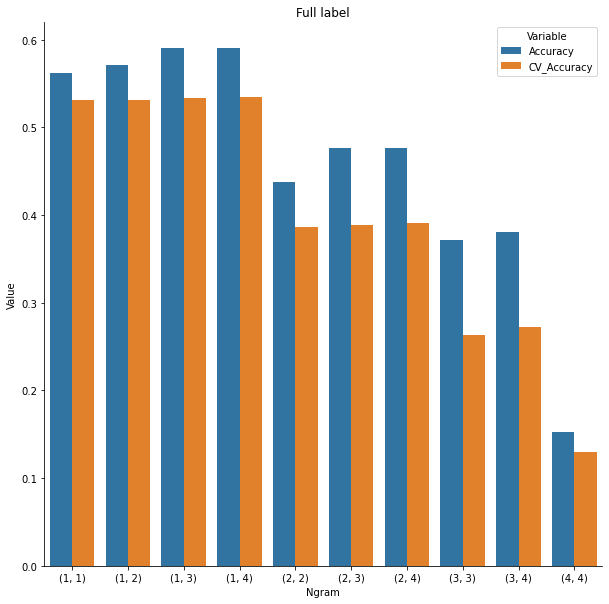

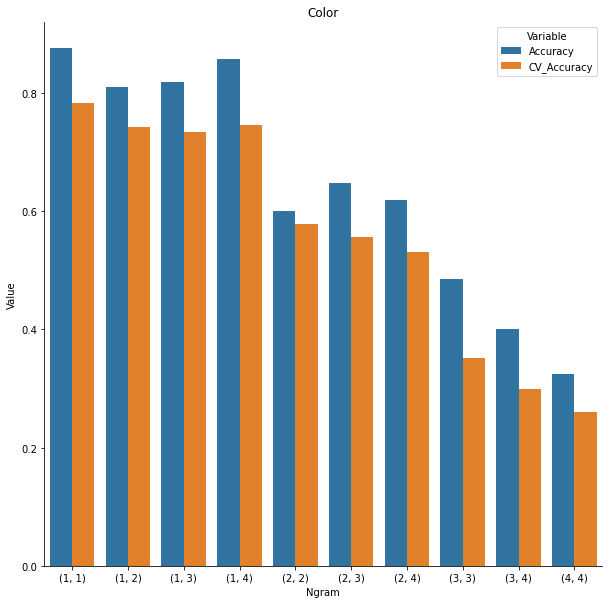

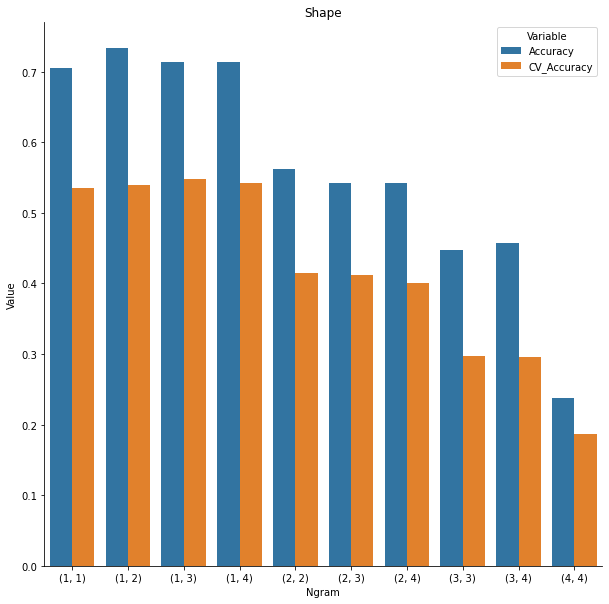

In [18]:
# plot with y = color + shape
plot_label = result_df[result_df['Label']=='label']
plot_label = plot_label.drop(columns=['Label'])

fig, ax1 = plt.subplots(figsize=(10, 10))
tidy = plot_label.melt(id_vars='Ngram').rename(columns=str.title)
sns.barplot(x='Ngram', y='Value', hue='Variable', data=tidy, ax=ax1).set_title('Full label')
sns.despine(fig)

# plot with y = color
plot_color = result_df[result_df['Label']=='color']
plot_color = plot_color.drop(columns=['Label'])

fig, ax1 = plt.subplots(figsize=(10, 10))
tidy = plot_color.melt(id_vars='Ngram').rename(columns=str.title)
sns.barplot(x='Ngram', y='Value', hue='Variable', data=tidy, ax=ax1).set_title('Color')
sns.despine(fig)

# plot with y = shape
plot_shape = result_df[result_df['Label']=='shape']
plot_shape = plot_shape.drop(columns=['Label'])

fig, ax1 = plt.subplots(figsize=(10, 10))
tidy = plot_shape.melt(id_vars='Ngram').rename(columns=str.title)
sns.barplot(x='Ngram', y='Value', hue='Variable', data=tidy, ax=ax1).set_title('Shape')
sns.despine(fig)

# from the figure, smaller n-grams performed bettwe than large n_grams

# Testing on Survey Data

In [24]:
df = pd.read_excel('processed_survey.xlsx')
print (df.shape)

(176, 3)


In [2]:
# split label into color and shape
df[['color','shape']] = df['label'].str.split(' ',expand=True)
#df

In [31]:
bow_survey = count_vec.transform(df['text'])

In [32]:
y_pred = label_model.predict(bow_survey)
color_pred = color_model.predict(bow_survey)
shape_pred = shape_model.predict(bow_survey)

com_pred = []
for c,s in zip(color_pred,shape_pred):
    com = c+' '+s
    com_pred.append(com)

In [41]:
# print accuracy
# this is accuracy on survey data
print('Acc on full label:', accuracy_score(np.array(df['label']), y_pred))
print('Acc on color:', accuracy_score(np.array(df['color']), color_pred))
print('Acc on shape:', accuracy_score(np.array(df['shape']), shape_pred))
print('Acc on color + shape:', accuracy_score(com_pred, y_pred))

Acc on full label: 0.4034090909090909
Acc on color: 0.7443181818181818
Acc on shape: 0.4431818181818182
Acc on color + shape: 0.6363636363636364
